## Mini-Projet: Séparation de sources hyperspectrale

Une image hyperspectrale est une image où un spectre contenant $D$ valeurs ou canaux est enregistré à chaque pixel. Cette modalité d'imagerie est très utilisée en imagerie satellitaire, où elle permet d'améliorer considérablement la résolution de la prise d'image. Dans le cas des images satellitaires, les pixels de l'image ont ainsi une résolution spatiale de l'ordre de la dizaine de mètres, de sorte que ces pixels mélangent les contributions des différents éléments présents sur la scène imagée (végétation, eau, minéraux du sol, habitations, routes, etc.). Nous nous intéressons ici à un problème, connu sous le nom de séparation de sources hyperspectrale, qui vise à identifier, pour une observation donnée, les spectres des constituants élémentaires présents dans une scène, ainsi que la proportion ("l'abondance") de ces constituants en chaque pixel de l'image.

L'objectif de ce mini-projet est d'implémenter un algorithme de séparation de source hyperspectral et de l'appliquer à une image satellitaire issue de la base de donnée SAMSON. L'image en question est de taille 95 x 95 pixels. Chaque pixel correspond à un spectre de 156 canaux, qui couvrent un intervalle de longueurs d'onde qui s'étend de 401 à 889 nm. La résolution spectrale est de 3.13 nm. Chaque spectre Y(x, y) mesuré au niveau du pixel (x, y) de l'image correspond à la combinaison linéaire des spectres *élémentaires* associés à l'eau, à la végétation et aux minéraux présents dans le sol:

$$
Y[x, y] = \alpha_{1} [x, y] m_1 + \alpha_2 [x, y] m_2 + (1 - \alpha_1[x, y] - \alpha_2[x, y]) m_3,
$$

où $\alpha_1[x, y]$ et $\alpha_2[x, y]$ correspondent aux proportions relatives d'eau et de végétation en surface à la position $[x, y]$, et $m_1$, $m_2$ et $m_3$ correspondent aux spectres élémentaires de l'eau, de la végétation et du sol minéral respectivement.



In [122]:
# -*- Encoding: Latin-1 -*-
#!/usr/bin/python

from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.linalg import eigh, det, norm

In [123]:
data_dict = loadmat("Samson.mat")
a = data_dict['A'].reshape((95*95, 3))
end = data_dict['M']
data = np.dot(a, end.T)

## 1. Visualisation des données

Le script ci-dessous permet de charger les données de l'image. Implémenter une fonction python permettant de visualiser:
- le spectre mesuré en un pixel de l'image
- l'image obtenue à une longueur d'onde donnée

In [130]:
def display_spectrum(img, loc,show=True):
    
    """
    Display the spectrum at location (x, y)
    
    :param img: Hyperspectral image
    :type img: 3D numpy array
    :param loc: Pixel location
    :type loc: tuple
    
    """
    x, y = loc
    lb = np.arange(401e-9, 889e-9, 3.13e-9)
    if (show):
        plt.plot(lb, img[x,y])
        plt.show()
    else:
        plt.plot(lb, img[x,y], '-+')
        return lb

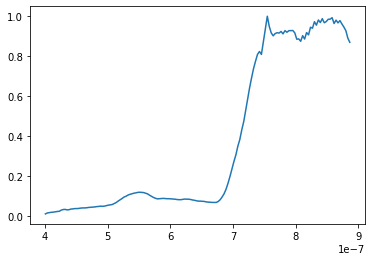

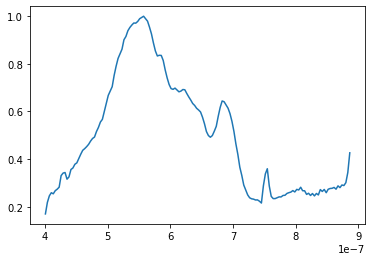

In [131]:
display_spectrum(data.reshape((95, 95, 156)), (50, 50))
display_spectrum(data.reshape((95, 95, 156)), (0, 0))

In [5]:
def display_band(img, spectr_idx):
    
    """
    Display the image corresponding to the specified spectral band
    
    :param img: Hyperspectral image
    :type img: 3D numpy array
    :param spectr_idx: Indexof the spectral band to display
    :type spectr_idx: int
    
    """
    bd = img[:,:,spectr_idx]
    # bd = img[spectr_idx][:][:] # ne fonctionne pas
    plt.imshow(bd)
    plt.show()

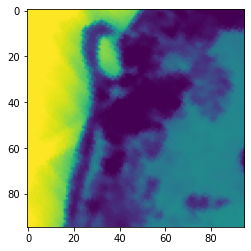

In [6]:
display_band(data.reshape((95, 95, 156)), 10) # 10, 100, 150 très différent

## 2. Réduction de dimension

Les spectres observés dans les données sont des vecteurs de dimension $D = 156$ et peuvent donc être représentées dans l'espace vectoriel $\mathbb{R}^D$. Ces spectres correspondent cependant à la combinaison linéaire de $K = 3$ spectres élémentaires, pondérés par les quantités positives $\alpha _1$, $\alpha_2$ et $\alpha_3$, qui correspondent à la proportion relative de chacun des spectres élémentaires. Par ailleurs, on a la relation de liaison supplémentaire:

$$
\alpha_1 + \alpha_2 + \alpha_3 = 1.
$$

Compte tenu de ces différentes relations, est-il possible de réduire la dimension des données, c'est à dire de déterminer un sous-espace de $\mathbb{R}^D$ qui contienne l'ensemble des points de données ? Quelle serait la dimension de cet espace ? En utilisant l'algorithme d'analyse en composantes principales (ACP, ou PCA en anglais) présenté dans les slides accompagnant le mini-projet, identifier le sous-espace en question. Projeter les données spectrales dans ce sous-espace, et afficher le résultat. Commenter le résultat. En particulier, comment explique-t-on la distribution géométrique des données spectrales?


Oui?
espace de dimension 3 car k=3?
afficher sous forme d'image ?
?

In [7]:
import scipy.sparse.linalg
def pca(data, K):

    """
    Principal component analysis (PCA)
    """

    N = len(data)

    # Compute the covariance matrix and the mean of the data
    m=np.mean(data,axis=0)
    L = len(m)
    C=np.cov(data.T)
    #print(Ci.shape)
    #C=np.matmul(data.T, data) # retrancher moyenner et 1/n
    #print(C[2,1]/Ci[2,1])
    #print(C.shape)
    #print(C[:2,:2]/9025, Ci[:2,:2])
    #print(C[1,2], C[2,1])
    #print("C", C.shape)
    #print("m", m.shape)
    

    # Computes the eigenvalues/eigenvectors of the covariance matrix
    # Extract the K largest eigenvectors
    #vals, vecs = scipy.sparse.linalg.eigsh(C, K)
    vals, vecs = scipy.linalg.eigh(C, subset_by_index=[L-K, L-1])
    #print(vals)
    #print(vecs)
    #scipy.linalg.eigh manuellement
    #print(vals)
    #print("VS", vecs.shape)

    

        
    # Project the data on the subpasce spanned by the K largest eigenvectors
    #Y = ...
    #return Y
    u = np.stack(vecs, axis=0).T
    #print("U", u.shape)
    #print("D", data.shape)
    #Y = np.zeros(N)
    #for i in range(N):
    #    b = data[i]-m
    #    Y[i] = np.matmul(u, b)
    Y = np.matmul(u, data.T-np.multiply(m[:,np.newaxis], np.ones(N)))
    #print(Y.shape)
    #print(Y)
    return Y.T

    #notation Y bof...

(9025, 2)


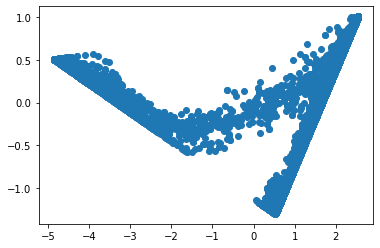

In [8]:
# plot the projected data
projected_data = pca(data, K=2)
print(projected_data.shape)
plt.scatter(projected_data[:,1],projected_data[:,0]) #inversion x et y
plt.show()

# 3. Détermination des spectres élémentaires

Dans l'espace de dimension réduite déterminé dans la question précédente, les données spectrales prennent la forme géométrique d'un simplexe. Les sommets de ce simplexe correspondent aux spectres élémentaires présents dans la scène. Implémenter l'algorithme N-FINDR décrit dans les slides accompagnant le mini-projet pour déterminer les spectres élémentaires.



In [117]:
import random

class nfindr:

    """
    NFINDR algorithm implementation
    """

    def __init__(self, projected_data, R):

        """
        Constructor

        :param projected_data: Projected data points
        :param R: Number of endmembers
        :type projected_data: Numpy array 
        :type R: int
        """

        self.projected_data = projected_data
        self.N, self.K = self.projected_data.shape    
        self.R = R 


    def set_endmembers(self):

        """
        Initialize the NFINDR algorithm 
        """

        # Randomly select R endmembers from the data points
        self.idx = np.random.choice(self.N, self.R, replace=False)
        self.endmembers = self.projected_data[self.idx, :]
        print(self.endmembers.shape)
        # itertools.combinations, comparer les temps

        # Compute the volume of the simplex
        self.volume = self.calc_vol(self.endmembers)
        
    def calc_vol(self, endm):
        # problème ici alors
        e = np.copy(endm)
        e = e[1:]-e[0]
        #print(e)
        #raise Exception()
        #print(e)

        # Compute the volume of the simplex
        #return 1/np.math.factorial(self.R)*np.abs(scipy.linalg.det(np.array(endm[1:])-base))
        return np.abs(np.linalg.det(e)) # pas besoin de R, facteur de proportionnalité...
        #return np.abs(e[0,0]*e[1,1]-e[1,0]*e[0, 1])

    def iterate(self):

        """
        N-FINDR Iteration
        """

        # Iterate over the endmembers
        modif = False
        for p in range(self.R):
            end = np.copy(self.endmembers)

            # Iterate over the data points
            for q in range(self.N):

                # Try replacing the selected endmember by the data point
                new_pt = self.projected_data[q]
                if (not self.projected_data[q] in end):
                    end[p] = new_pt

                # Update the endmember if the volume is greater
                    v = self.calc_vol(end)
                    if (v > self.volume):
                    #print(v)
                        self.volume = v
                        #self.endmembers = end # cause le bug ? end est modifié à la suite de la boucle, toutes les maj
                        self.endmembers[p] = new_pt
                        self.idx[p] = q
                        modif = True


        return modif


    def run(self):

        """
        Run the algorithm
        """

        # Randomly select endmembers within the data points
        self.set_endmembers()
        #self.display_endmembers()

        # Iterate until idempotence is reached
        #i = 0
        while self.iterate():
            continue
            #i+=1
            #self.display_endmembers()
            #print("new")
            #continue
        #print(i)

        # Display result
        self.display_endmembers()
            

    def display_endmembers(self):

        """
        Scatter plot of the simplex data
        """
        #print(self.endmembers)
        #print(self.endmembers[1:]-self.endmembers[0])
        #print(self.volume)
        plt.scatter(self.projected_data[:,1],self.projected_data[:,0])
        plt.scatter(self.endmembers[:,1], self.endmembers[:, 0])
        #inversion x et y
        plt.show()


(9025, 2)
(3, 2)


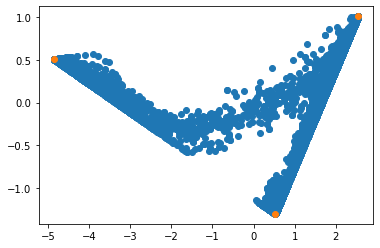

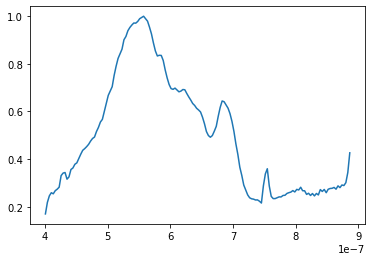

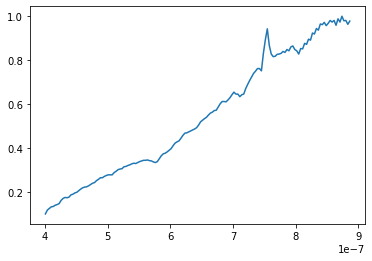

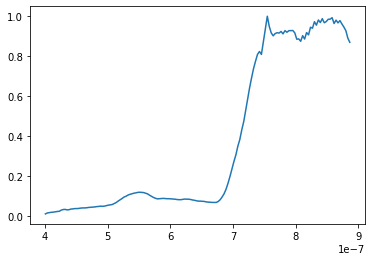

0 0
6449 6449
5167 5167


In [119]:
print(projected_data.shape) #ne pas transposer pour affichage mieux
inst = nfindr(projected_data, R=3)
inst.run()

i0 = inst.idx[0]
i1 = inst.idx[1]
i2 = inst.idx[2]
display_spectrum(data.reshape((95, 95, 156)), (i0//95, i0%95))
display_spectrum(data.reshape((95, 95, 156)), (i1//95, i1%95))
display_spectrum(data.reshape((95, 95, 156)), (i2//95, i2%95))
print(i0, i0//95*95+i0%95)
print(i1, i1//95*95+i1%95)
print(i2, i2//95*95+i2%95)

# 4. Détermination des abondances

Nous cherchons maintenant à identifier les abondances de chacun des spectres, c'est à dire à déterminer, en chaque point, quelle est la proportion relative de chacun des spectres élémentaires identifiés dans l'étape précédente. Pour ce faire, nous cherchons à résoudre, à chaque pixel de l'image, le problème d'optimisation suivant:

$$
\alpha := \arg \min \| Y[x, y] - \sum_{i = 1}^3 \alpha _{i}[x, y] m_i \|^2
$$

sous les contraintes 

$$
\forall i = 1,2,3, \quad \alpha_i \geq 0
$$

et 

$$
\sum_{i = 1}^3 \alpha_i = 1.
$$

Pour résoudre ce problème, appliquer un algorithme de descente de gradient projeté, tel que décrit dans les slides.

In [183]:
class projected_gradient:

    """
    Projected gradient descent implementation for solving
    minimize ||Ma - y||^2 s.t 0 <= a <= 1.
    """

    def __init__(self, M, y):

        """
        Constructor
        
        :param M: endmembers matrix
        :param y: spectra
        """
        
        self.M = M
        self.R = self.M.shape[1]
        self.D = self.R-1 # à revoir
        #self.D, self.R = self.M.shape
        #print("DR", self.D, self.R)
        #print(self.M)
        self.y = y
        #print(self.y)
        self.a = np.zeros(self.R)[np.newaxis].T
        #print(self.a)
        #self.f = norm(np.dot(self.M, self.a) - self.y, ord = 2)
        self.beta = 0.5
        self.alpha = 0.001 # choix arbitraire ?
        self.lambd = 1.
        #print("f0", self.fun(self.a))


    def iterate(self):

        """
        Iteration of the projected gradient descent algorithm
        """

        # revoir le code intial

        # Compute the gradient
        
        
        next = True
        while(next):

            # Proximal operator
            

            # Line search
            pass

    def fun(self, a):
        v = np.squeeze((np.dot(self.M, a) - self.y).T)
        vr = np.dot(v,v)
        #
        # print ("VR", vr)
        return vr

    def grad_fun(self):
        tmp = np.dot(self.M, self.a)-self.y
        #print("T", tmp)
        #print(tmp.shape)
        #print(self.M.T.shape)
        return 2*np.dot(self.M.T, tmp)
                
    def step_size(self):
        self.t = 1
        while self.fun(self.a - self.t*self.ga) > (self.f - self.alpha*self.t*self.nga):
            self.t = self.beta * self.t    

    def proj(self, a):
        a[a > 1] = 1
        a[a < 0] = 0
        return a # pas besoin car référence ?

        #différence np.dot et multiply matrice

    def run(self, eps, maxiter):

        """
        Run the proximal gradient algorithm

        :param eps: Requested precision 
        :param maxiter: Maximal number of iteration
        """

        for i in range(maxiter):
            #print("SA", self.a)
            self.f = self.fun(self.a)
            self.ga = self.grad_fun()
            #print("GA", self.ga)
            #print(self.ga.shape)
            self.nga = np.linalg.norm(self.ga, 2)
            if (self.nga < eps):
                #print(self.nga)
                #print(i, "iterations")
                break
            self.step_size()
            #print("T", self.t)
            self.a = self.proj(self.a - self.t*self.ga)
            if (i==(maxiter-1)):
                print(self.nga)
                print("maxit")
        
        #print("end", self.a)
        

In [201]:
def display_abundances(abundances):

    """
    Display the abundances maps

    :param abundances: Abundances map
    :type abunbances: Numpy array
    """

    # faire subplot

    im0 = plt.imshow(abundances[:,:,0])
    plt.gcf().colorbar(im0)
    plt.figure()

    im1 = plt.imshow(abundances[:,:,1])
    plt.gcf().colorbar(im1)
    plt.figure()

    im2 = plt.imshow(abundances[:,:,2])   
    plt.gcf().colorbar(im2) 

    plt.show()


0


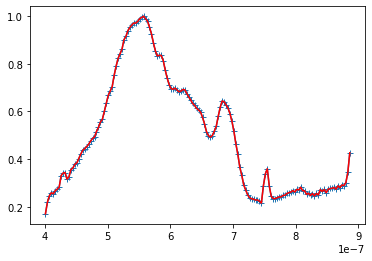

100
200
300
400
500
600
700
800
900
1000


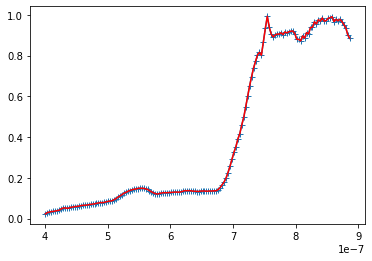

1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


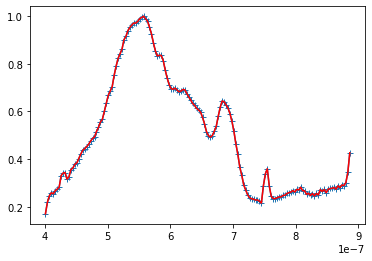

2100
2200
2300
2400
2500
2600
2700
2800
2900
3000


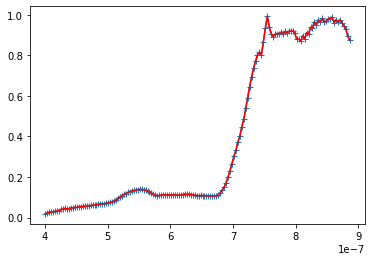

3100
3200
3300
3400
3500
3600
3700
3800
3900
4000


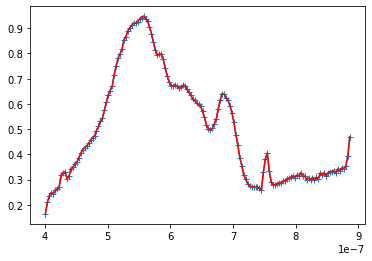

4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


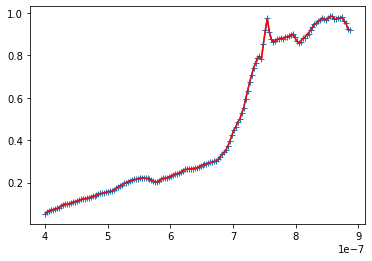

5100
5200
5300
5400
5500
5600
5700
5800
5900
6000


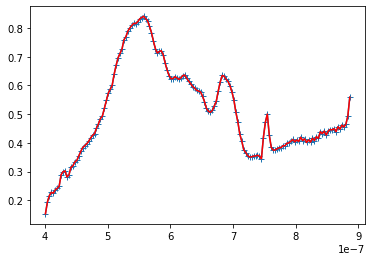

6100
6200
6300
6400
6500
6600
6700
6800
6900
7000


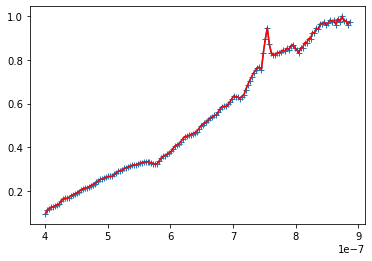

7100
7200
7300
7400
7500
7600
7700
7800
7900
8000


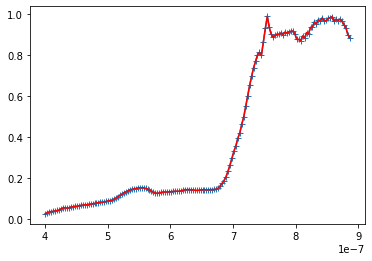

8100
8200
8300
8400
8500
8600
8700
8800
8900
9000


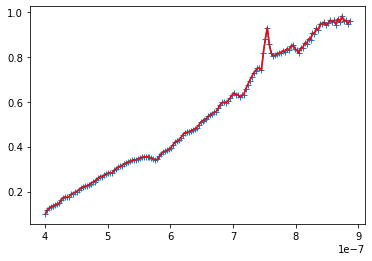

[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]
 ...
 [6.74829739e-02 9.32508414e-01 1.08337668e-04]
 [7.31322655e-02 9.26920517e-01 1.12656179e-04]
 [5.82937832e-02 9.41688937e-01 1.18937025e-04]]


In [190]:
# Abundances estimation
import copy
endmembers = copy.deepcopy(inst.endmembers) # à voir dans partie précédente comment codé...
N, D = projected_data.shape
#print(N,D)
#print(endmembers.shape)

R = D + 1 # Number of endmembers
abundances = np.zeros((N, R))
    
# Trick for handling the sum-to-one constraint (see slides)
#print(endmembers)
#print(np.identity(D))
def process(z):
    em = copy.deepcopy(endmembers.T)
    vert = np.array([1]*R)[np.newaxis]
    #print(em)
    #print(em.shape)
    m = np.vstack((em, vert)) # besoin de transposer ? # optimiser opération
    #print(em.shape)
    #print(m)
    #print(m.shape)
    #print(projected_data[z][np.newaxis].T.shape)
    y = np.vstack((copy.deepcopy(projected_data[z][np.newaxis].T), np.array([1]))) # ça ou transposée, coordonnées ? idem dans M car carré
    #print(y) # erreur énoncé 1D ?
    #print(m)
    pg = projected_gradient(m,y)
    pg.run(1e-2, 10000) # noter nb simulations ? bon eps et maxiter ?
    # bloqué à 0.25 gradient, bizarre ?
    #print(pg.a)
    return pg.a

process(1)
#abundances = process(np.arange(N)) # régler bugg
for i in range(N):
    abundances[i] = process(i).squeeze()
    if (i%100==0):
        print(i)
    if (i%1000==0):
        #print("aff")
        #print(abundances[i])
        lb = display_spectrum(data.reshape((95, 95, 156)), (i//95, i%95), False)
        y_app = abundances[i][0]*data[i0]+abundances[i][1]*data[i1]+abundances[i][2]*data[i2]
        #print(y_app)
        plt.plot(lb, y_app, '-', color = 'red')
        plt.show()

print(abundances)

# bonne valeur pour lambda : plus est faible, mieux c'est...

In [ ]:
# from PIL import Image
# img = Image.open("lena.png")

(9025, 3)


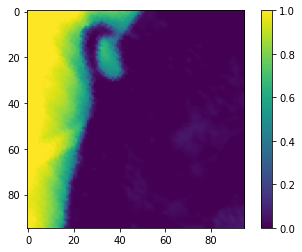

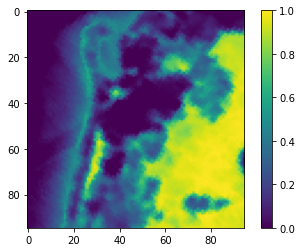

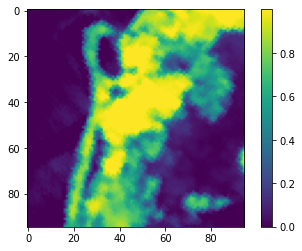

In [202]:
print(abundances.shape)
#lambda : paramètre de gradient min ? assez étrange
display_abundances(abundances.reshape((95, 95, 3)))
